# Conclusion
## 7.1 

### Assignment Solution - Classify Cloud Images using Inception

In [1]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 501kB 22.5MB/s 
     |████████████████████████████████| 3.1MB 28.1MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [0]:
LIST_OF_LABELS = "cirrus,cumulonimbus,cumulus".split(',')
HEIGHT = 300
WIDTH = 300
NUM_CHANNELS = 3
NCLASSES = len(LIST_OF_LABELS)
BATCH_SIZE = 32

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Create file lists for images

In [0]:
train_file_list, train_category_list, test_file_list, test_category_list = [], [], [], []

In [0]:
for i in range(1, 20):
    _0 = '/content/gdrive/My Drive/clouds/cirrus/{}.jpg'.format(i)
    _1 = '/content/gdrive/My Drive/clouds/cumulonimbus/{}.jpg'.format(i)
    _2 = '/content/gdrive/My Drive/clouds/cumulus/{}.jpg'.format(i)
    train_file_list.append(_0)
    train_category_list.append(0)
    train_file_list.append(_1)
    train_category_list.append(1)
    train_file_list.append(_2)
    train_category_list.append(2)
train_file_df = pd.DataFrame({'filename': train_file_list, 'class': train_category_list})

In [0]:
for i in range(20, 21):
    _0 = '/content/gdrive/My Drive/clouds/cirrus/{}.jpg'.format(i)
    _1 = '/content/gdrive/My Drive/clouds/cumulonimbus/{}.jpg'.format(i)
    _2 = '/content/gdrive/My Drive/clouds/cumulus/{}.jpg'.format(i)
    test_file_list.append(_0)
    test_category_list.append(0)
    test_file_list.append(_1)
    test_category_list.append(1)
    test_file_list.append(_2)
    test_category_list.append(2)
test_file_df = pd.DataFrame({'filename': test_file_list, 'class': test_category_list})

In [19]:
train_file_df.head()

,filename,class
0,/content/gdrive/My Drive/clouds/cirrus/1.jpg,0
1,/content/gdrive/My Drive/clouds/cumulonimbus/1...,1
2,/content/gdrive/My Drive/clouds/cumulus/1.jpg,2
3,/content/gdrive/My Drive/clouds/cirrus/2.jpg,0
4,/content/gdrive/My Drive/clouds/cumulonimbus/2...,1


### Try to read a file

In [21]:
img = tf.io.read_file(test_file_df['filename'][0])
img = tf.image.decode_jpeg(img, channels=3)
print(img)

tf.Tensor(
[[[ 38  76 139]
  [ 38  76 139]
  [ 40  78 143]
  ...
  [ 97 128 175]
  [ 97 128 175]
  [ 98 129 176]]

 [[ 39  77 140]
  [ 39  77 140]
  [ 40  78 141]
  ...
  [ 97 128 175]
  [ 97 128 175]
  [ 99 130 177]]

 [[ 40  78 141]
  [ 40  78 141]
  [ 40  78 141]
  ...
  [ 96 128 175]
  [ 97 128 175]
  [ 99 130 177]]

 ...

 [[ 52  61  58]
  [ 49  58  57]
  [ 49  58  63]
  ...
  [  2   4   1]
  [  3   3   1]
  [  0   0   0]]

 [[ 38  48  39]
  [ 35  44  39]
  [ 43  53  54]
  ...
  [  4   6   1]
  [  4   5   0]
  [  0   1   0]]

 [[ 14  24  13]
  [ 12  23  15]
  [ 23  33  34]
  ...
  [  4   6   1]
  [  5   6   1]
  [  1   2   0]]], shape=(629, 1024, 3), dtype=uint8)


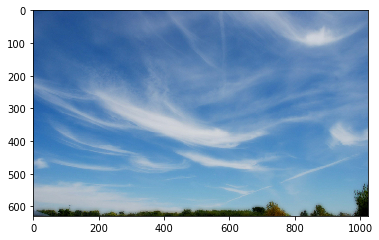

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img)

### Data Preprocessing

In [23]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=NUM_CHANNELS)
  image = tf.image.resize(image, [HEIGHT, WIDTH])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

path_ds = tf.data.Dataset.from_tensor_slices(train_file_list)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_category_list, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

ds = image_label_ds.shuffle(buffer_size=1000 * BATCH_SIZE)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>

### Initialize Pre-trained Inception

In [5]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 18s 0us/step


In [0]:
base_model.trainable = False

### Create Model

In [13]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(NCLASSES, activation='softmax')
])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 3075      
Total params: 56,963,299
Trainable params: 2,626,563
Non-trainable params: 54,336,736
__________________________________

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(ds, epochs=3, steps_per_epoch=10)

Epoch 1/3
10/10 [==============================] - 206s 21s/step - loss: 0.4335 - accuracy: 0.8250
Epoch 2/3
10/10 [==============================] - 196s 20s/step - loss: 0.1354 - accuracy: 0.9500
Epoch 3/3
10/10 [==============================] - 194s 19s/step - loss: 0.0412 - accuracy: 0.9937
